# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [22]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [23]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '071301oci'  # Define your experiment name to save models and results
save_pth = '/Users/xingyanli/Lab/gestar2_regression/liquid_ice/' # the directory to save models and results
exp = 't'

In [24]:
max_value = 2.5
min_value = -2

In [25]:
cls_w = 0.6

## Load prep-processed data

In [26]:
X_train_t = torch.load(f'data/X_train_{exp}.pt')
y_train_t = torch.load(f'data/y_train_{exp}.pt')

X_val_t = torch.load(f'data/X_val_{exp}.pt')
y_val_t = torch.load(f'data/y_val_{exp}.pt')

X_test_t = torch.load(f'data/X_test_{exp}.pt')
y_test_t = torch.load(f'data/y_test_{exp}.pt')

In [27]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_val = Data.TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = 64, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_val, batch_size = 64, shuffle=True, pin_memory=True)

# Network

In [28]:
class MultiTask(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 32),
      nn.ReLU(),
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 256),
      nn.ReLU(),
    )
    self.cls = nn.Sequential (
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
      nn.Softmax()
    )
    self.reg = nn.Sequential (
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    feature = self.encoder(x)
    classification = self.cls(feature)
    regression = self.reg(feature)

    return classification, regression

In [29]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# Optimization

In [30]:
# Initialize the MLP
model = MultiTask(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_cls = nn.CrossEntropyLoss()
loss_reg = nn.MSELoss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [31]:
print(model)

MultiTask(
  (encoder): Sequential(
    (0): Linear(in_features=233, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
  )
  (cls): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
    (5): Softmax(dim=None)
  )
  (reg): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [32]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
train_loss_cls = []
train_loss_reg = []
valid_loss_cls = []
valid_loss_reg = []

# Select model based on validation loss
valid_loss_min = 10.0

file = open("results/{}oci_log.txt".format(expname),"w")
early_stopping = EarlyStopping(tolerance=50, min_delta=0)

for epoch in range(200): 
  
  # Set current loss value
  train_loss = 0.0
  train_cls = 0.0
  train_reg = 0.0

  valid_loss = 0.0
  valid_cls = 0.0
  valid_reg = 0.0

  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    # Get predictions
    output_cls, output_reg = model(b_x)
    output_reg = output_reg*(max_value-min_value)+min_value

    # Get ground truth values
    ground_truth_cls = torch.stack((b_y[:,0],b_y[:,1],b_y[:,2]), -1)
    ground_truth_reg = torch.reshape(b_y[:,3], [-1,1])
    ground_truth_reg = ground_truth_reg*(max_value-min_value)+min_value

    '''
      Loss function
      L_cls: Cross Entropy loss of all predictions
      L_reg: masked regression loss of cloudy pixels 
    '''
    l_cls = loss_cls(output_cls, ground_truth_cls)
    l_reg = loss_reg(output_reg, ground_truth_reg)

    loss = cls_w*l_cls + (1-cls_w)*l_reg
    l_cls.requires_grad_(True)
    l_reg.requires_grad_(True)
    file.write(f'Train CLS Loss: {l_cls:.3f}, Train REG Loss: {l_reg:.3f} \n') 

    optimizer.zero_grad
    loss.backward()
    optimizer.step()

    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
    train_cls += l_cls.item() * b_x.size(0)
    train_reg += l_reg.item() * b_x.size(0)
  train_loss_all.append(train_loss / train_num)
  train_loss_cls.append(train_cls / train_num)
  train_loss_reg.append(train_reg / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    # Get predictions
    output_cls_valid, output_reg_valid = model(c_x)
    output_reg_valid = output_reg_valid*(max_value-min_value)+min_value
    # Get ground truth values
    ground_truth_cls_valid = torch.stack((c_y[:,0],c_y[:,1],c_y[:,2]), -1)
    ground_truth_reg_valid = torch.reshape(c_y[:,3], [-1,1])
    ground_truth_reg_valid = ground_truth_reg_valid*(max_value-min_value)+min_value

    l_cls_v = loss_cls(output_cls_valid, ground_truth_cls_valid)
    l_reg_v = loss_reg(output_reg_valid, ground_truth_reg_valid)
    file.write(f'Valid CLS Loss: {l_cls_v:.3f}, Valid REG Loss: {l_reg_v:.3f} \n') 

    loss_v = cls_w*l_cls_v + (1-cls_w)*l_reg_v
    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)
    valid_cls += l_cls_v.item() * c_x.size(0)
    valid_reg += l_reg_v.item() * c_x.size(0)
  valid_loss_all.append(valid_loss / valid_num)
  valid_loss_cls.append(valid_cls / valid_num)
  valid_loss_reg.append(valid_reg / valid_num)
  
  # print(f'epoch: {epoch}, pred: {output_cls}\n')

  print(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f}')  
  file.write(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f} \n')

  if (valid_loss / valid_num) <= valid_loss_min:
    valid_loss_min = (valid_loss / valid_num)
    torch.save(model.state_dict(), './models/{}_min_valid_loss.pth'.format(expname))

  early_stopping((train_loss / train_num), (valid_loss / valid_num))
  if early_stopping.early_stop:
    print("Early stopping at epoch:", epoch)
    break
  
file.write(f'Minimum Valid Loss: Epoch {epoch} - {valid_loss_min:.3f} \n')
file.close() #to change file access modes
print('Training process has finished.')

/Users/xingyanli/opt/anaconda3/envs/gestar2/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 - Train Loss: 1.506, Valid Loss: 1.198
Epoch 2 - Train Loss: 1.093, Valid Loss: 1.018
Epoch 3 - Train Loss: 0.948, Valid Loss: 0.875
Epoch 4 - Train Loss: 0.844, Valid Loss: 0.808
Epoch 5 - Train Loss: 0.822, Valid Loss: 0.842
Epoch 6 - Train Loss: 0.803, Valid Loss: 0.764
Epoch 7 - Train Loss: 0.777, Valid Loss: 0.770
Epoch 8 - Train Loss: 0.753, Valid Loss: 0.760
Epoch 9 - Train Loss: 0.745, Valid Loss: 0.727
Epoch 10 - Train Loss: 0.712, Valid Loss: 0.703
Epoch 11 - Train Loss: 0.691, Valid Loss: 0.686
Epoch 12 - Train Loss: 0.682, Valid Loss: 0.691
Epoch 13 - Train Loss: 0.691, Valid Loss: 0.669
Epoch 14 - Train Loss: 0.696, Valid Loss: 0.689
Epoch 15 - Train Loss: 0.670, Valid Loss: 0.649
Epoch 16 - Train Loss: 0.664, Valid Loss: 0.672
Epoch 17 - Train Loss: 0.668, Valid Loss: 0.660
Epoch 18 - Train Loss: 0.661, Valid Loss: 0.645
Epoch 19 - Train Loss: 0.638, Valid Loss: 0.625
Epoch 20 - Train Loss: 0.634, Valid Loss: 0.642
Epoch 21 - Train Loss: 0.627, Valid Loss: 0.636
E

In [33]:
valid_loss_min

0.5890476047876146

In [34]:
PATH = './models/{}_oci.pth'.format(expname)
torch.save(model.state_dict(), PATH)

# Training Loss Plot

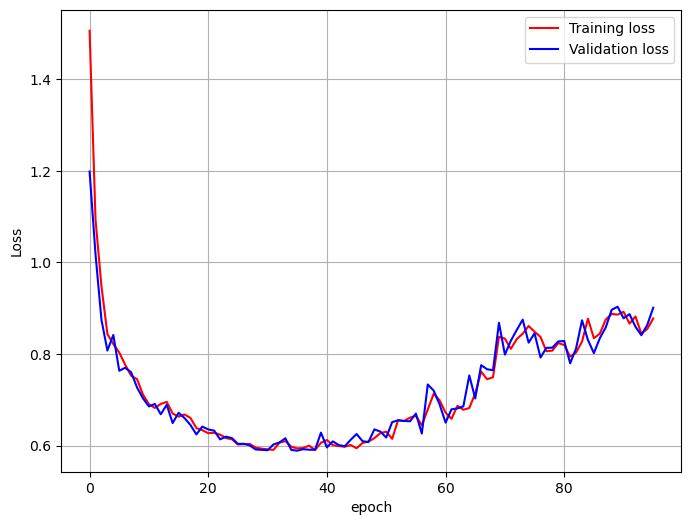

In [35]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'r-', label = 'Training loss')
plt.plot(valid_loss_all, 'b-', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('./results/{}_loss.png'.format(expname))
plt.show()

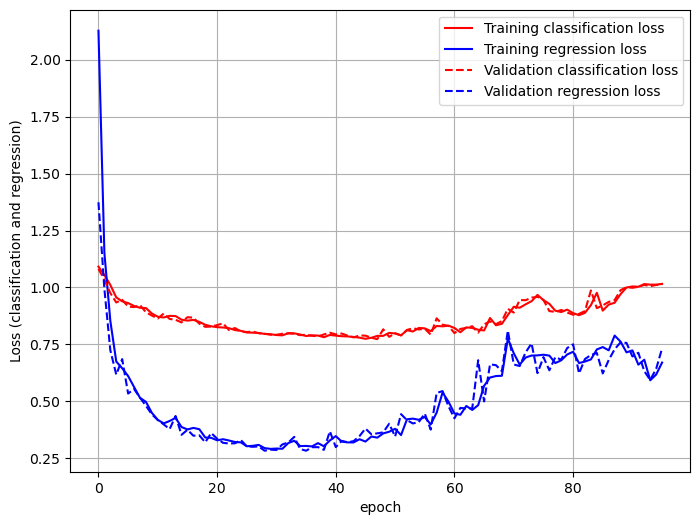

In [36]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_cls, 'r-', label = 'Training classification loss')
plt.plot(train_loss_reg, 'b-', label = 'Training regression loss')
plt.plot(valid_loss_cls, 'r--', label = 'Validation classification loss')
plt.plot(valid_loss_reg, 'b--', label = 'Validation regression loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss (classification and regression)')
plt.savefig('./results/{}_loss_detail.png'.format(expname))
plt.show()